### Одноклассовый классификатор на основе трехслойного автоэнкодера

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
np.bool = np.bool_
np.int = np.int_
np.object = np.object_
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorboard.plugins.hparams import api as hp
import keras_tuner as kt

#### Загрузка данных

In [ ]:
normal_train_data = tf.convert_to_tensor(np.load('normal_train_data.npy'))
normal_test_data = tf.convert_to_tensor(np.load('normal_test_data.npy'))
anomalous_train_data = tf.convert_to_tensor(np.load('anomalous_train_data.npy'))
anomalous_test_data = tf.convert_to_tensor(np.load('anomalous_test_data.npy'))
train_data = np.load('train_data.npy')
test_data = tf.convert_to_tensor(np.load('test_data.npy'))
train_labels = np.load('train_labels.npy')
test_labels = tf.convert_to_tensor(np.load('test_labels.npy'))
from sklearn.utils import shuffle

In [74]:

from sklearn.decomposition import PCA

t_d_1 = tf.convert_to_tensor(np.concatenate((normal_train_data[:500].numpy(),anomalous_train_data[:500].numpy())))
y = tf.convert_to_tensor(np.concatenate((np.ones(500, dtype=int), np.zeros(500, dtype=int))))

pca = PCA(n_components=10)  # Set number of components to 24
train_data_reduced = tf.convert_to_tensor(pca.fit_transform(t_d_1, y))
validation_data_reduced = tf.convert_to_tensor(pca.fit_transform(test_data, test_labels))

np.save('train_data_reduced.npy', train_data_reduced)
np.save('validation_data_reduced.npy', validation_data_reduced)

In [75]:



class BinaryClassfier(Model):
  def __init__(self):
    super(BinaryClassfier, self).__init__()

    self.encoder = tf.keras.Sequential([
      layers.Dense(1, activation="relu")])

  def call(self, x):
    encoded = self.encoder(x)
    return encoded

  
def model_builder():
  
  model = BinaryClassfier()
  model.compile(optimizer='adam', loss='mean_squared_error', metrics= ["accuracy"])
  return model

autoencoder = model_builder()
history = autoencoder.fit(train_data_reduced, y, epochs=30,
          validation_data=(validation_data_reduced, test_labels))

Epoch 1/30
32/32 [==============================] - 0s 8ms/step - loss: 0.4026 - accuracy: 0.4950 - val_loss: 0.4707 - val_accuracy: 0.4070
Epoch 2/30
32/32 [==============================] - 0s 6ms/step - loss: 0.3701 - accuracy: 0.4940 - val_loss: 0.4352 - val_accuracy: 0.4060
Epoch 3/30
32/32 [==============================] - 0s 5ms/step - loss: 0.3378 - accuracy: 0.4930 - val_loss: 0.3985 - val_accuracy: 0.4110
Epoch 4/30
32/32 [==============================] - 0s 5ms/step - loss: 0.3054 - accuracy: 0.4930 - val_loss: 0.3615 - val_accuracy: 0.4150
Epoch 5/30
32/32 [==============================] - 0s 5ms/step - loss: 0.2742 - accuracy: 0.4960 - val_loss: 0.3269 - val_accuracy: 0.4220
Epoch 6/30
32/32 [==============================] - 0s 5ms/step - loss: 0.2460 - accuracy: 0.5010 - val_loss: 0.2962 - val_accuracy: 0.4300
Epoch 7/30
32/32 [==============================] - 0s 5ms/step - loss: 0.2207 - accuracy: 0.5200 - val_loss: 0.2673 - val_accuracy: 0.4480
Epoch 8/30
32/32 [==

Overall Accuracy = 0.97

Classification Report:
              precision    recall  f1-score   support

       False       0.97      0.96      0.96       408
        True       0.97      0.98      0.98       592

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



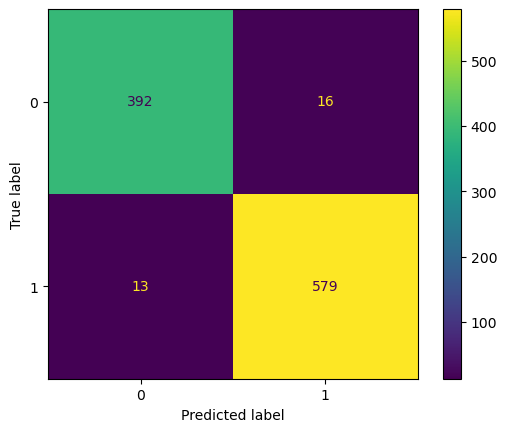

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
def predict(model, data, threshold):
  reconstructions = model.predict(data)
  return [not i  for i in tf.math.less(reconstructions, threshold)]

def print_stats(predictions, labels):
    # Calculate overall accuracy
    accuracy = accuracy_score(labels, predictions)
    print("Overall Accuracy = {:.2f}".format(accuracy))
    # Print the classification report for a detailed view
    print("\nClassification Report:")
    print(classification_report(labels, predictions))
    
    
preds = predict(autoencoder, validation_data_reduced, 0.5)

print_stats(preds, test_labels)
ConfusionMatrixDisplay(confusion_matrix(test_labels, preds)).plot()